In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_csv("../data/fraud_data.csv")

In [3]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [4]:
df = df.sort_values(by='step')  


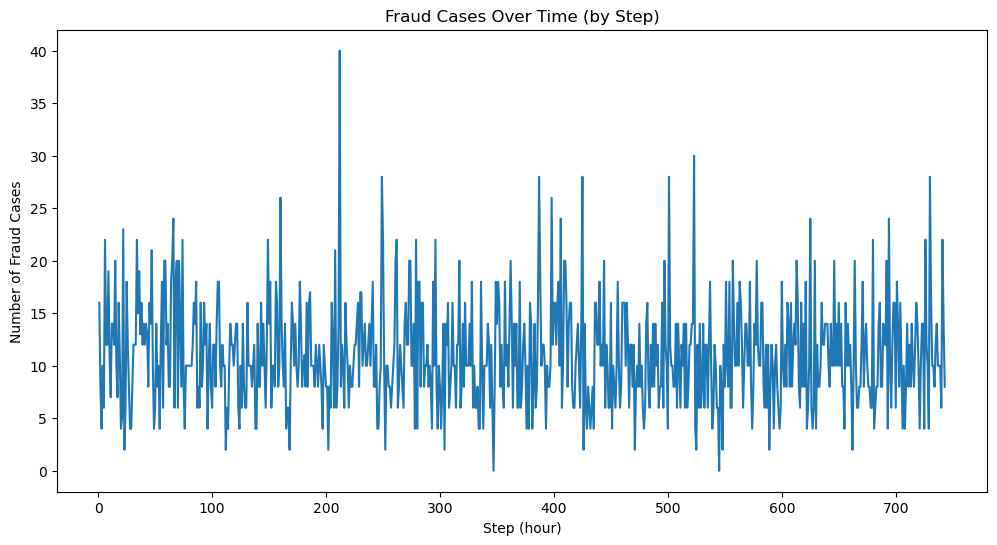

In [5]:
import matplotlib.pyplot as plt

fraud_by_step = df.groupby('step')['isFraud'].sum()
plt.figure(figsize=(12, 6))
plt.plot(fraud_by_step)
plt.title('Fraud Cases Over Time (by Step)')
plt.xlabel('Step (hour)')
plt.ylabel('Number of Fraud Cases')
plt.show()


In [6]:
split_step = int(0.8 * df['step'].max())  # 80% of the time range
train = df[df['step'] <= split_step]
test = df[df['step'] > split_step]


In [7]:
X_train = train.drop(["isFraud", "step"], axis=1)
X_test = test.drop(["isFraud", "step"], axis=1)
y_train = train["isFraud"]
y_test = test["isFraud"]

In [8]:
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest"]
categorical = ["type"] 

In [9]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(drop="first"), categorical)
])

In [10]:
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Pipeline
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(sampling_strategy="minority", random_state=42)),
    ("classifier", xgb_clf)
])

In [11]:
# Train
pipeline.fit(X_train, y_train)

c:\Users\Ayush\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:48:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'newbalanceDest',
                                                   'oldbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [12]:
# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[121368    558]
 [     3   1651]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    121926
           1       0.75      1.00      0.85      1654

    accuracy                           1.00    123580
   macro avg       0.87      1.00      0.93    123580
weighted avg       1.00      1.00      1.00    123580



In [13]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities for the positive class
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Find precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 for each threshold
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

# Best threshold
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}, F1 Score: {f1[best_idx]:.4f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))


Best Threshold: 0.9571, F1 Score: 0.9404
Confusion Matrix:
 [[121741    185]
 [    22   1632]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    121926
           1       0.90      0.99      0.94      1654

    accuracy                           1.00    123580
   macro avg       0.95      0.99      0.97    123580
weighted avg       1.00      1.00      1.00    123580



In [14]:
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_pred_opt).ravel()
cost_1 = 10000*fn1 + 100*fp1
print(f"The cost incurred with this model is = ₹{cost_1}")

The cost incurred with this model is = ₹238500


**Observation** : Cost incurred by this model = ₹238500, after metric based threshold tuning

Threshold tuning based on cost

In [15]:
thresholds = np.linspace(0.01, 0.99, 100)
best_threshold = 0.5
min_cost = float('inf')
best_preds = None
def cost_sensitive_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fn * 10000 + fp * 100
    return cost
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    cost = cost_sensitive_score(y_test, y_pred_thresh)
    
    if cost < min_cost:
        min_cost = cost
        best_threshold = thresh
        best_preds = y_pred_thresh

# Final output
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Minimum Cost: ₹{min_cost:,}")
print("Classification Report at Best Threshold:\n")
print(classification_report(y_test, best_preds, digits=4))


Best Threshold: 0.6732
Minimum Cost: ₹68,700
Classification Report at Best Threshold:

              precision    recall  f1-score   support

           0     1.0000    0.9968    0.9984    121926
           1     0.8101    0.9982    0.8944      1654

    accuracy                         0.9968    123580
   macro avg     0.9050    0.9975    0.9464    123580
weighted avg     0.9974    0.9968    0.9970    123580



**Observation** : Cost incurred by this model = ₹68,700, after cost based threshold tuning

In [16]:
print("Confusion Matrix:\n", confusion_matrix(y_test, best_preds))

Confusion Matrix:
 [[121539    387]
 [     3   1651]]


In [17]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import joblib

# Save the model
joblib.dump(pipeline, '../models/Time_based_XGBoost_ADASYN.pkl')

joblib.dump((X_test, y_test), '../test_data/Time_based_XGBoost_ADASYN_Test.pkl')


['D:\\IEOR\\3rd Sem\\Fraud detection\\Test\\Time_based_XGBoost_ADASYN_Test.pkl']